# Variational Quantum Classifier and Quantum Kernel Estimator

In this notebook, we are going to look at the **Variational Quantum Classifier** and the **Quantum Kernel Estimator** algorithms which are used in classification problems in the **QSVM** (Quantum Support Vector Machine) architecture in a Supervised Learning setting. The **variational quantum classifier** (which will be referred to as **'VQC'** from hereon) is a linear classifier and is a way to perform classification on a Quantum Computer (QC) using the primal formulation of the binary classification problem. **Quantum Kernel Estimator** (which will be referred to as **'QKE'** from hereon) is an algorithm to find Kernels (and equivalently feature spaces) that helps solve certain types of classification tasks better. It is the quantum way to solve binary classification using the dual version of the classification problem.

We will begin with a brief overview of the binary classification problem and formulate the problem in both the primal and dual forms. We then explain how a **variational quantum algorithm** can be used to solve a binary classification problem (in the primal form) by extracting the expectation value of a particular unitary using a quantum circuit and treating it as the target variable for the quantum model. Then we transition into the **QKE** algorithm and explain how we can extract kernels using a quantum computer. We will need a little bit of math too, which we explain at places where it is needed.

Before going on to explore these topics, let us perform a few necessary imports : 

In [2]:
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap

# Introduction to Classification Problems

In this section we are going to discuss binary classification problem where the Machine Learning model has to classify data into two different classes. 

Consider that we have two different types of data (e.g. the pictures of a cat or a dog) and we want our model to classify whether a new picture shown to it, is that of a cat or a dog. The picture shown has pixels in it it and each pixel will have features (like colour, brightness, different levels of red, green and blue) and each picture has a large number of such features, each of which can be represented by a number. A list of all the features of a particular input data (a picture in this case) can be encoded into a vector with a large number of dimensions. We are given a large number of pictures (vectors) and their corresponding classes that they belong to, either a cat or a dog (each of these two categories can be represented by a numeric label say, +1 and -1 or 0 and 1). Our task in a classification problem is that once we get a new picture (vector), we need to determine which class it belongs to cat or dog. In other words, once we are given a vector we need to assign it a numerical label.

![1_sOLdPdDlWQ4yHMxeT-LJsg.png](attachment:1_sOLdPdDlWQ4yHMxeT-LJsg.png )

Above is a depiction of out cat and dog classification problem. The cats are labelled blue and the doga are labelled red. The x and y axis represent the numerical values of features (which may be whisker length, colour, shape). It can be seen that the features of dogs are similar to each other and that of the cats are close to each other. As a result, it is expected that while representing our data in the space of all its features (provided they are choosen well), data of one category will form clusters and as a result we can separate them by a line, plane or hyperplane (depending on the number of dimensions of our space which is also in many cases, equal to the number of features that we have). In some cases, we can get lucky and can separate the two types of data by a straight line or plane or hyperplane but in mnay cases they cannot be separated by a linear function and we are forced to take our data into a higher dimensional space (called feature space) where we hope that the data is linearly separable.

Let us first look into the case where the data is linearly separable. We will take only two feature for convenient pictorial depiction but we can have as many features (or dimensions) that we like.
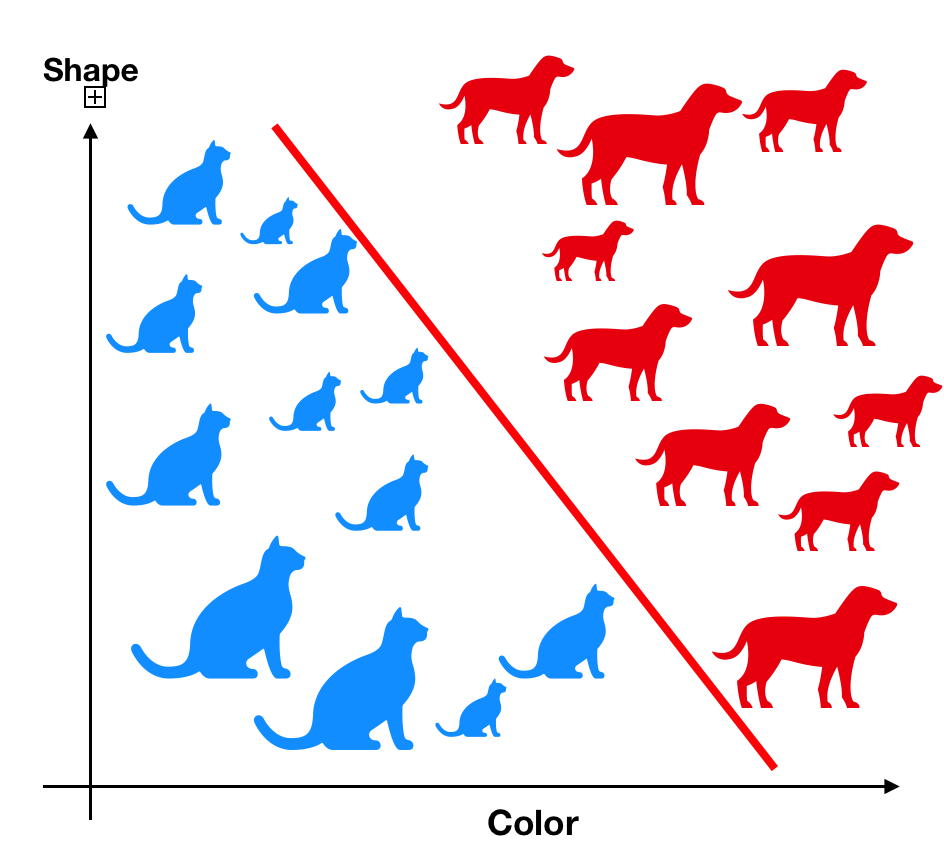

# Classical Support Vector Machine

Let us imagine a situation where all the features of a particular data is represented using a vector $x$ and we are given a set of $x$'s and their corresponding label $y = {0,1}$. We have to find a way to reliably assign each of the $x$'s (we call them training set because we know their labels and can use them to train our models) to their corresponding $y$'s so that when we encounter a new data (called test data since we are testing the reliability of our data on this type of new, unseen data) we can also assign it it's label. We also would like to use another vector (actually a transpose vector) $\theta^{T}$ which has what we call trainable parameters and we use it to go from our data vectors $x$'s to our corresponding labels $y$ through the relation : $f(\theta^{T}x) = y$. We can think of our prediction as being a very confident one that $y = 1$ if $\theta^{T} > 0$. Similarly, we think of our model as making a very confident prediction of $y = 0$, if $\theta^{T} < 0$.

Consider the following figure, in which x’s represent positive training examples, o’s denote negative training examples, a decision boundary (this is the line given by the equation $\theta^{T}x = 0$ , and is also called the separating hyperplane) is also shown, and three points have also been labeled A, B and C.

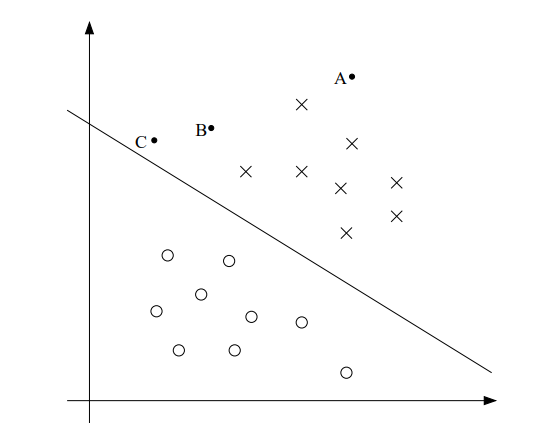


Notice that the point A is very far from the decision boundary. If we are
asked to make a prediction for the value of y at at A, it seems we should be
quite confident that $y = 1$ there. Conversely, the point C is very close to
the decision boundary, and while it’s on the side of the decision boundary
on which we would predict $y = 1$, it seems likely that just a small change to
the decision boundary could easily have caused out prediction to be $y = 0$.
Hence, we’re much more confident about our prediction at A than at C. The
point B lies in-between these two cases, and more broadly, we see that if
a point is far from the separating hyperplane, then we may be significantly
more confident in our predictions

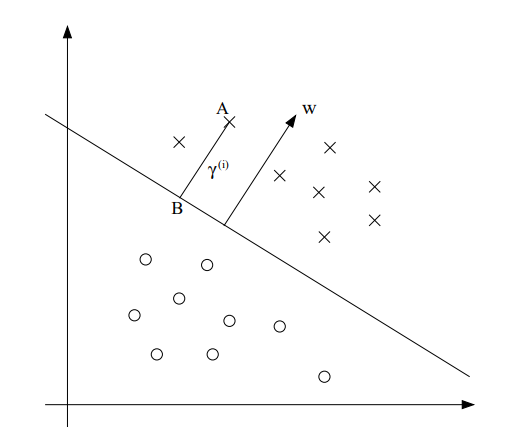

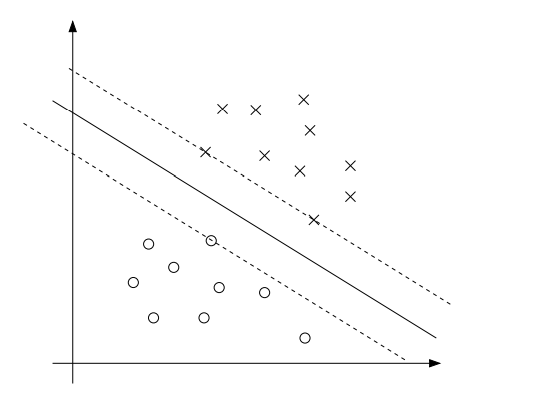

Below is an illustration of the situation where we have data that is not linearly separable.

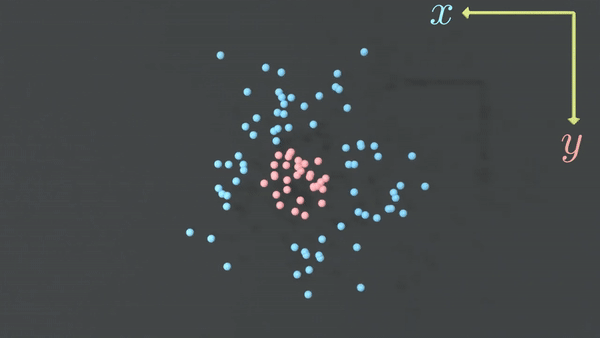

In the above situation, the data is not linearly separable, so any kind of optimizer cannot be used to find a linear decision boundary to separate the two classes of data. In such case, we map the original data vectors (points) into a higher dimensional space (called a feature space and this type of transformation is called a feature map) and "hope" that in this  higher dimensional space the two classes of data become linearly spearable and the task now is to find a linear decision boundary (separating hyperplane) in this space and map the decision boundary back into the original space. We can clearly see that the linear decision boundary in the higher dimensional feature space is a non-linear decision boundary in the original space (in the above example, the original space of two features has a 1-dimensional non-linear (round) decision boundary whereas in the feature space of three features, the decision boundary becomes a 2-dimensional plane (linear). Another important thing to note is that while going from a low dimensional space to a higher dimensional feature space, we do not actually include any new type of features but rather use a non-linear combination of out original features (The fact that in the opriginal space has a non-linear decision boundary which becomes linear in a feature space is an artifact of this very fact).

# Variational Quantum Classifier (VQC)

The Variational Quantum Classifier is a Variational Quantum Algorithm (VQA) that is used to solve the primal formulation of a binary classification problem. At first, we need to find a way to encode data (all the features of a datapoint) into a quantum state $|\Phi(\mathbf{x})\rangle|$. This is done through the application of the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding. 

##  Quantum Feature Maps

A quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the hermitian matrix $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$ which is the density matrix corresponding to the pure quantum state$|\Phi(\mathbf{x})\rangle|$ obtained by the application of the unitary $\mathcal{U}_{\Phi(\mathbf{x})}$ on state $|0\rangle^{n}$ . Each type of feature map has an associated quantum circuit which generates the state $|\Phi(\mathbf{x})\rangle|$. 

The feature maps that  are currently available in Qiskit are [**`PauliFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html), [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html), [**`ZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html). Among them, the **ZZFeatureMap** is conjectured to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices.

### Pauli Feature Map
The `PauliFeatureMap` is defined as: 

```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

and describes the unitary operator of depth $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

$U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$
    
The argument **feature_dimension** refers to the number of features that we want to encode and is related to the number of qubits, this relation between the number of features and the number of qubits depends on the type of data encoding used (which has been discussed in a different notebook). 

The argument **reps** refers to the number of times a particular feature map (quantum circuit for data encoding) is repeated (in layers). 

The argument **entanglement** refers top the type of way entangling gates are applied between pairs of qubits. A 'full' entanglement means that all the pairs of qubits are connected by entangling gates. In the case of a Pauli Map, we need to explicitly specefy entangling gates in the **Paulis** parameter, otherwise there will be no entangling gates.

The argument **Paulis** refers to the rotational gates of the pauli operators (**X, Y, Z**) that are used in the feature map.

The argument **insert_barriers** is a boolean value that determines whether barriers are used betyween the blocks.

Below is the code for a Pauli Feature Map. Try changing the above parameters to get a flavour of what these parameters do and what a eature map looks like.    

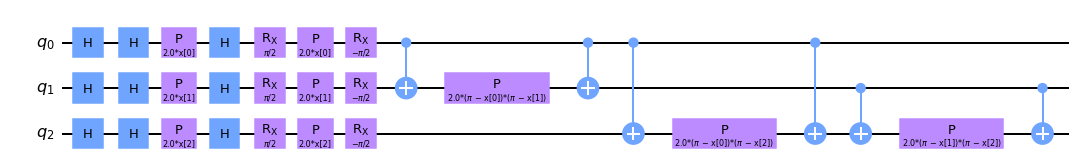

In [8]:
# The Pauli gates used here are X, Y and Z.
# The number of features is 3, which in this case is also equal to the number of qubits. So, we have 3 qubits.
# The entanglement is full meaning that each pair of qubits have entangling gates betwen them.
# Try changing the parameters and see how the circuit changes.
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, entanglement='full', paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl') #to draw the quantum circuit corresponding to  the feature map.

A little bit of playing around has been done for you (We will change feature_dimension, reps(depth) and entanglement).

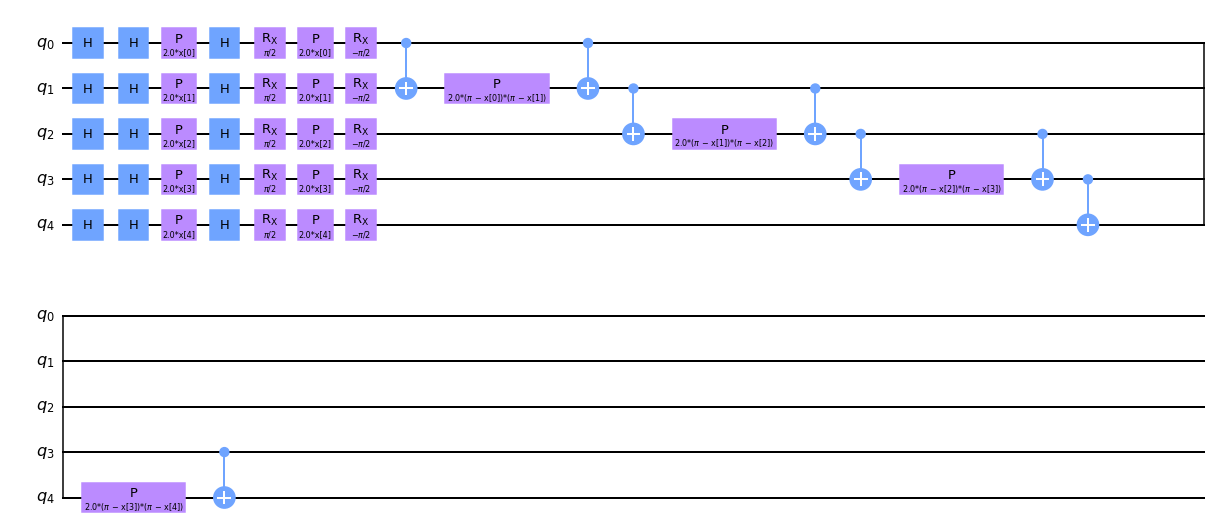

In [4]:
# 5 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=5, reps=1, entanglement='linear', paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')
# This circuit has 5 qubits since in this type of mapping the number of qubits equals the number of features.
# The depth is 1.
# The entanglement is linear meaning that a qubit is connected to only the next qubit . e.g q0 to q1, q1 to q2 ... q3 to q4.

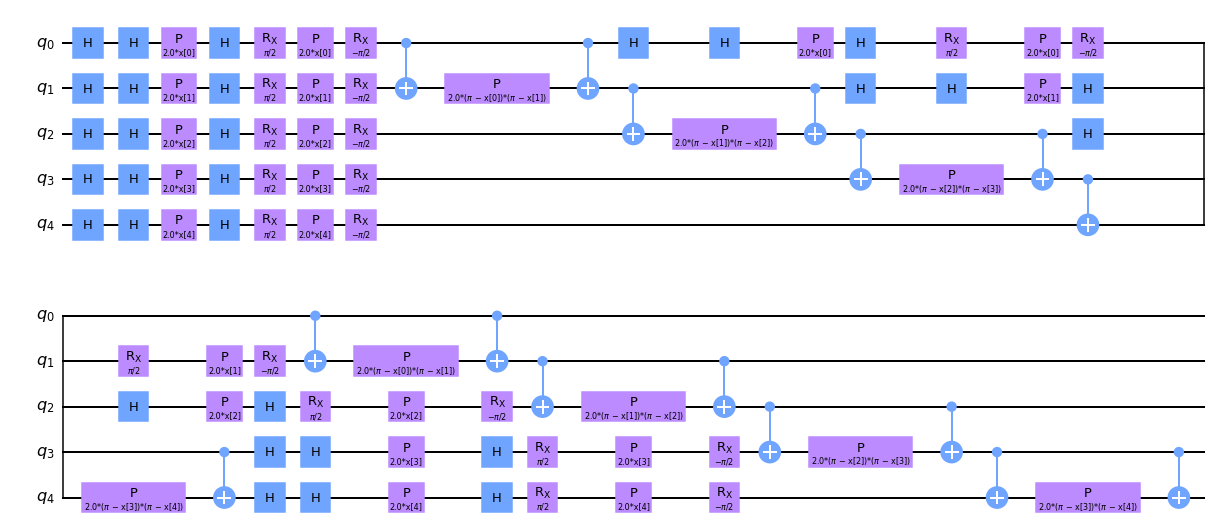

In [6]:
# 5 features, depth 2 ... we can see that incresing reps leads to another repetation of the map and increases the depth
map_pauli = PauliFeatureMap(feature_dimension=5, reps=2, entanglement='linear', paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

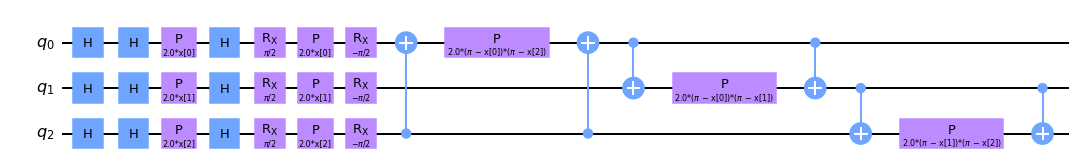

In [8]:
#  3 features, 1 rep
# entanglement is circular meaning that it has a linear entanglement in addition to the last qubit having entangling gates with the first qubit
# e.g. circular entaglement is linear entanglement + 'last qubit (q2) connected to first qubit (q0)'
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, entanglement='circular', paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

### Z Feature Map

The `ZFeatureMap` is defined as:

```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

It is represented by the unitary $$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ and corresponds to a Pauli Feature Map where $k = 1, P_0 = Z$ and the arguments mean the same as in the case of the Pauli Feature Map.

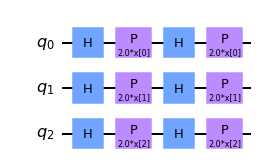

In [9]:
# Z Feature Map with 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

Clearly, the above circuit is easy to simulate classically since we have no entanglement and each qubit can be dealt separately. So, the `ZFeatureMap` does not give any quantum advantage. Next we shall try to build this map using `PauliFeatureMap` by changing the suitable parameter. 

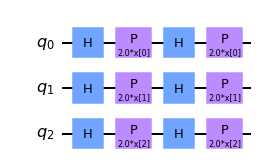

In [10]:
# We construct a Z Feature Map using a Pauli Feature Map since Z Feature Map is a type of Pauli Feature Map
map_z_pauli = PauliFeatureMap(feature_dimension=3, reps=2, paulis=['Z'])
map_z_pauli.decompose().draw('mpl')

Clearly, we can see that the `ZFeatureMap` can also be constructed using `PauliFeatureMap` as the above two circuits are exactly the same.

### ZZ Feature Map

The `ZZFeatureMap` is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```
and is represented by the Unitary $$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

which is the same as a `PauliFeatureMap` where $k = 2, P_0 = Z, P_1 = ZZ$. The parameters mean the same as before. 

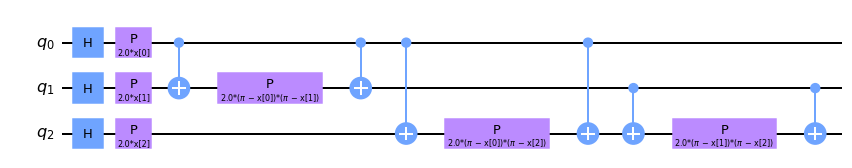

In [11]:
# The ZZ Feature Map with 3 features, depth 1
# The entanglement is full by default
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw('mpl')

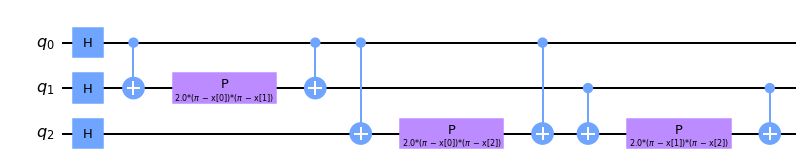

In [15]:
# Here we construct the ZZ Feature Map using the Pauli Feature Map and we can see that it is the same as the circuit above.
map_zz_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['ZZ'])
map_zz_pauli.decompose().draw('mpl')

We can change the entanglement which is full by default.

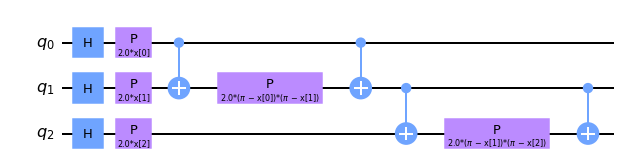

In [12]:
# The ZZ Feature Map with 3 features, depth 1
# The entanglement is linear
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

So we have seen how to encode data as quantum circuits. Now, the main idea in VQC is to extract the expectation value of a particular unitary from the circuit. 

After encoding we also need trainable parameters in the circuit. So, we add rotational gates with variable parameters that we can modify while training. Then, we extract the expectation value of a particular unitary $H$. This expectation value is the target variable $y$ in Classical ML. From there we estimate the cost function and can train the model accordingly, by changing the values of the parameters in the circuit. This can be done through off the shelf softwares and classical optimizers.

Given below is a quantum circuit through which we accomplish this.
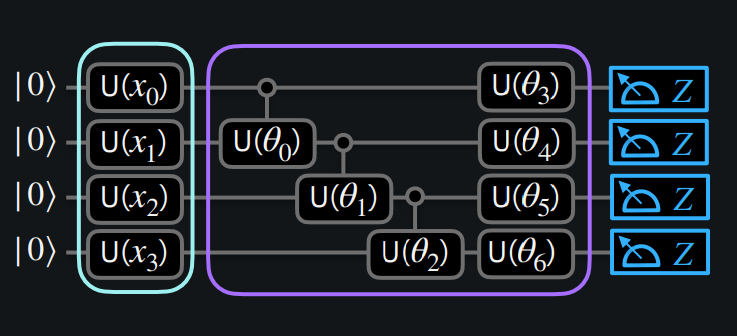

In the above circuit (Source: Qiskit Global Summer School 2021 Lecture Notes), the first part is for encoding the features of the data into the circuit whereas the next part (violet) has trainable parameters.

Given below is the same circuit : 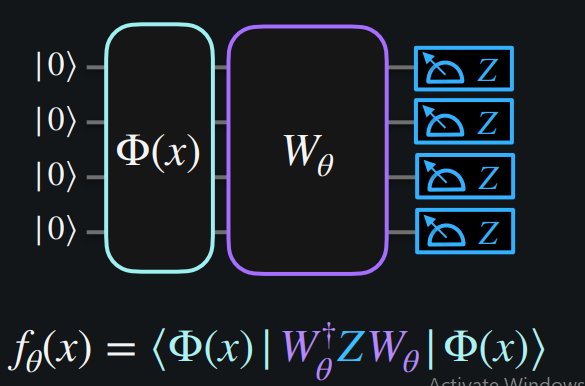

Here, we are taking expectation of the pauli Z operator but we can actually do this with respect to any operator.So, the idea is to find the right $W_{\theta}$ such that $\textit{label}(\mathbf{x})=sign(f_{\theta}(\mathbf{x}))=sign(\langle\phi(\mathbf{x})|W_{\theta}^{\dagger}ZW_{\theta}|\phi(\mathbf{x})\rangle)$

$f_{\theta}(\mathbf{x})=\langle\phi(\mathbf{x})|W_{\theta}^{\dagger}ZW_{\theta}|\phi(\mathbf{x})\rangle$ and let us define $W_{\theta}^{\dagger}ZW_{\theta}=H_{\theta}$


$$\implies f_{\theta}(\mathbf{x})=\langle\phi(\mathbf{x})|H_{\theta}|\phi(\mathbf{x})\rangle$$

$$=Tr[\langle\phi(\mathbf{x})|H_{\theta}|\phi(\mathbf{x})\rangle]$$

$$   =Tr[H_{\theta}|\phi(\mathbf{x})\rangle\langle\phi(\mathbf{x})|]$$

since $Tr[AB]=Tr[BA]$

$$ \implies  f_{\theta}(\mathbf{x})=Tr[H_{\theta}.\phi(\mathbf{x})]$$

Where $\phi(\mathbf{x})=|\phi(\mathbf{x})\rangle\langle\phi(\mathbf{x})|$

Now,

$$H_{\theta}=\frac{1}{2^{n}}\sum_{\alpha \in 4^n} \langle H_{\theta},P_{\alpha}\rangle P_{\alpha}   $$

where $ \langle H_{\theta},P_{\alpha}\rangle = Tr[ H_{\theta} P_{\alpha}]$ is the Hilbert-Schmidt Inner Product (also called Trace Inner Product) of two matrices.

$$ \implies H_{\theta}=\frac{1}{2^{n}}\sum_{\alpha \in 4^n} Tr[ H_{\theta} P_{\alpha}] P_{\alpha} $$

and

$$ \phi(\mathbf{x})= \frac{1}{2^{n}}\sum_{\alpha \in 4^n} Tr[\phi(\mathbf{x}) P_{\alpha}] P_{\alpha} $$

and let us define :

$$ h_{\alpha}(\theta)=Tr[H_{\theta}P_{\alpha}]$$

$$ \phi_{\alpha}(\mathbf{x})= Tr[\phi(\mathbf{x})P_{\alpha}]$$

So, we have : 

$$H_{\theta}=\frac{1}{2^{n}}\sum_{\alpha \in 4^n}h_{\alpha}(\theta)P_{\alpha}$$

and 
$$\phi(\mathbf{x})= \frac{1}{2^{n}}\sum_{\alpha \in 4^n}\phi_{\alpha}(\mathbf{x})P_{\alpha}$$

So, $$P_{\alpha}P_{\beta}=Tr[H_{\theta}.\phi(\mathbf{x})]$$

$$ = Tr[(\frac{1}{2^{n}}\sum_{\alpha \in 4^n}h_{\alpha}(\theta)P_{\alpha})(\frac{1}{2^{n}}\sum_{\alpha \in 4^n}\phi_{\alpha}(\mathbf{x})P_{\alpha})]$$

$$ =\frac{1}{4^{n}}Tr[\sum_{\alpha , \beta \in 4^n}h_{\alpha}(\theta)\phi_{\beta}(\mathbf{x})P_{\alpha}P_{\beta}] $$

$$ =\frac{1}{4^{n}}\sum_{\alpha , \beta \in 4^n}h_{\alpha}(\theta)\phi_{\beta}(\mathbf{x})Tr[P_{\alpha}P_{\beta}] $$


Now, $Tr[P_{\alpha}P_{\beta}]=2^n$ if $\alpha=\beta$ or $0$ otherwise.

$$ \implies f_{\theta}(\mathbf{x})=\frac{1}{2^{n}}\sum_{\alpha , \beta \in 4^n}h_{\alpha}(\theta)\phi_{\beta}(\mathbf{x}) $$

Now,

$$\textit{label}=\textit{sign}(f_{\theta}(\mathbf{x}))=\textit{sign}(\frac{1}{2^{n}}\sum_{\alpha , \beta \in 4^n}h_{\alpha}(\theta)\phi_{\beta}(\mathbf{x}))$$


# Quantum Kernel Estimator (QKE)

The QKE algorithm is an alternative to the VQC algorithm for binary classification. Instead of optimizing the classifier by directly extracting the target variable (extracting the expectation value of a particular quantum circuit) and computing the cost function, we generate a kernel matrix by calculating the kernel for each pair of the data points. We calculate each of the kernels using measurements on a quantum circuit. It is the quantum way to solve the dual formulation of the classification problem.

Primal formulation -->  VQC

Dual formulation  -->  QKE

In order to solve the binary classification problem in the dual formulation, we need to define the notion of a quantum kernel. Just as in the classical case, the kernel is actually the inner product of two datapoints (vectors). We have already defined how to encode data into quantum states through a quantum feature map. For a vector with $n$ features we have quantum states of $2^n$ dimensions ( $2^{n+1}-2$ degrees of freedom ) and corresponding unitaries of $4^n$ dimensions ( $4^n-1$ degrees of freedom ). We can see that by treating unitaries as vectors we have access to a very large number which is a necessary requirement if the data is not linearly separable in fewer dimensions in the classical case. We have unitaries $\phi(\mathbf{x})$ for which we can define which are $k(\mathbf{x}_i,\mathbf{x}_j)= Tr(\phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i))$ as the kernel or a measure of distance or similarity between the data points $\phi(\mathbf{x}_j)$ and $\phi(\mathbf{x}_j)$. The closer these two points (matrices) are, with repect to their trace inner product, the larger the value of the kernel.

Now, $$Tr(\phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i))=Tr[  |\phi(\mathbf{x}_j)\rangle\langle \phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle \langle\phi(\mathbf{x}_i)|  ]$$ 


$$=\langle \phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle Tr [ |\phi(\mathbf{x}_j)\rangle\langle\phi(\mathbf{x}_i)| ]$$ 


$$ =\langle \phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle Tr [\langle \phi(\mathbf{x}_i)|\phi(\mathbf{x}_j)\rangle]$$


$$  \implies k(\mathbf{x}_i,\mathbf{x}_j)= \langle \phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle.\langle \phi(\mathbf{x}_i)|\phi(\mathbf{x}_j)\rangle$$


$$= \langle \phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle.\langle \phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle^* $$ 


$$=  |\langle \phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle |^2 $$


$$=\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}$$


So, it is clearly obvious from here how a kernel is computed. The kernel between points $i$ and $j$ is the probability of obtaining $| 0^{\otimes n} \rangle$ bitstring after the application of $\mathbf{U_\phi}(\mathbf{x_i})$ and $\mathbf{U_\phi^\dagger}(\mathbf{x}_j)$ to the $| 0^{\otimes n} \rangle$ state. Clearly, we cannot find the exact probability since we can only estimate the probability by a finite number of circuit measurements and improve the accuracy by increasing the number of shots (measurements). Since, we can never get the exact probability and can only estimate that, this algorithm gets the quantum kernel estimation algorithm.

Moreover, we can clearly see that all the kernel values for any pair of datapoints is non-negative as it is a probability. Thus, all the entries of the kernel matrix are positive and satisfy the Mercer's conditions for a valid kernel. So, quantum kernels are valid kernels.

Here is a representation of the **QKE** algorithm (Credit : [***Liu et al.* arXiv:2010.02174 (2020)**](https://arxiv.org/abs/2010.02174))

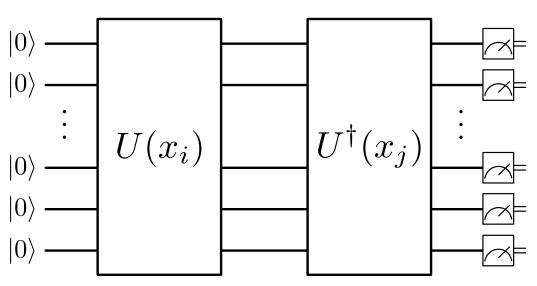

# This is an incomplete notebook, other details and code coming up soon.